In [1]:
import sys
import os
from pathlib import Path

scripts_dir = Path().resolve()
parent_dir = scripts_dir.parent
sys.path.insert(0, str(parent_dir))

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import SSM
from SSM.ssm.plots import gradient_cmap, white_to_color_cmap

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import numpy as np
import pandas as pd
import seaborn as sns

import scipy
import pyarrow

import torch

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pymc3 as pm

import Functions.inference as inference
import Functions.kinematics as kinematics
import Functions.learning as learning

!ls /ceph/aeon

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")
    
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

short_sessions = sessions.iloc[[4,16,17,20,23,24,25,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [24]:
display(short_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
4,BAA-1100700,26.3,26.3,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
16,BAA-1101818,26.2,26.7,2022-06-21 10:27:42.615139961,2022-06-21 13:15:50.564740181,0 days 02:48:07.949600220
17,BAA-1101819,25.4,26.4,2022-06-21 13:28:10.593659878,2022-06-21 16:34:29.241280079,0 days 03:06:18.647620201
20,BAA-1101818,26.4,28.0,2022-06-23 08:39:04.261089801,2022-06-23 11:14:46.121759892,0 days 02:35:41.860670091
23,BAA-1101818,26.9,27.8,2022-06-24 09:32:37.183360100,2022-06-24 12:29:54.365859985,0 days 02:57:17.182499885
24,BAA-1101823,27.9,27.9,2022-07-14 12:53:15.740799904,2022-07-14 16:35:05.846270084,0 days 03:41:50.105470180
25,BAA-1101821,25.0,26.0,2022-07-15 13:14:40.239679813,2022-07-15 15:47:44.568860054,0 days 02:33:04.329180241
28,BAA-1101818,26.7,29.5,2022-08-15 10:25:01.651199818,2022-08-15 13:04:50.849309921,0 days 02:39:49.198110103
29,BAA-1101819,27.5,30.0,2022-08-15 13:11:23.791259766,2022-08-15 16:10:27.350080013,0 days 02:59:03.558820247
30,BAA-1101818,26.5,30.1,2022-08-16 09:25:53.963200092,2022-08-16 12:34:02.296770096,0 days 03:08:08.333570004


In [9]:
display(long_sessions)

,id,weight_enter,weight_exit,enter,exit,duration
8,BAA-1100699,26.75,29.0,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
10,BAA-1100701,26.70,30.6,2022-04-04 15:54:07.945059776,2022-04-08 16:34:36.183650017,4 days 00:40:28.238590241
11,BAA-1100699,29.00,28.2,2022-04-20 11:51:24.997630119,2022-04-28 10:02:56.655809879,7 days 22:11:31.658179760
14,BAA-1100702,27.00,28.9,2022-05-03 11:08:12.660739899,2022-05-12 09:21:42.411650181,8 days 22:13:29.750910282


In [25]:
for i in range(len(short_sessions)):
    title = 'ShortSession' + str(i)
    print(title)
    try:
        P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
        sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
        print('sigma_a: ', sigma_a)
        print('sigma_x: ', sigma_x)
        print('sigma_y: ', sigma_y)
        print('sqrt_diag_V0: ', sqrt_diag_V0_value)
        
        print(" ")
    except FileNotFoundError: continue

ShortSession0
sigma_a:  214.12889099121094
sigma_x:  -0.5866673798271702
sigma_y:  0.3635427066052031
sqrt_diag_V0:  52.63426146106122
 
ShortSession1
sigma_a:  136.4071044921875
sigma_x:  0.4751876603956538
sigma_y:  0.1930825613531352
sqrt_diag_V0:  53.35174238978601
 
ShortSession2
sigma_a:  504.87884521484375
sigma_x:  0.7613704454108411
sigma_y:  1.6495740120860443
sqrt_diag_V0:  215.6021540192916
 
ShortSession3
sigma_a:  422.48626708984375
sigma_x:  -0.4660510221125924
sigma_y:  0.19663594525980846
sqrt_diag_V0:  152.91396538130388
 
ShortSession4
sigma_a:  232.239501953125
sigma_x:  -0.5222532679091298
sigma_y:  0.30354362596848455
sqrt_diag_V0:  68.18996748692327
 
ShortSession5
sigma_a:  244.88157653808594
sigma_x:  -0.2029959934513377
sigma_y:  -0.7442065242262328
sqrt_diag_V0:  83.86288791764395
 
ShortSession6
sigma_a:  99.7579345703125
sigma_x:  -0.10978131313458078
sigma_y:  0.21133249741003102
sqrt_diag_V0:  32.98934508089078
 
ShortSession7
sigma_a:  290.8110656738281


In [11]:
for i in range(4):
    title = 'LongSession' + str(i)
    print(title)
    try:
        P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
        sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']
        print('sigma_a: ', sigma_a)
        print('sqrt_diag_V0: ', sqrt_diag_V0_value)
        print(" ")
    except FileNotFoundError: continue

LongSession0
sigma_a:  236.20263671875
sqrt_diag_V0:  51.061492297298834
 
LongSession1
sigma_a:  240.68421936035156
sqrt_diag_V0:  59.89037970518794
 
LongSession2
sigma_a:  210.2962188720703
sqrt_diag_V0:  48.120707393978876
 
LongSession3
sigma_a:  194.5465087890625
sqrt_diag_V0:  68.78434102918425
 


In [12]:
Manual = np.load('../Data/MouseKinematicParameters/ShortSessions_LL_Manual.npy', allow_pickle=True)
Learned = np.load('../Data/MouseKinematicParameters/ShortSessions_LL_Learned.npy', allow_pickle=True)

In [13]:
Manual

array([  -50.75167087,   -33.7864688 ,   -55.46295733,   -91.97254088,
         -28.98819496,   -42.7243799 ,   -42.29880334, -1330.15819116,
         -37.5178155 ,   -46.46203257,   -45.12113761,   -39.93614478])

In [14]:
Learned

array([   -4.07062939,   -11.17530799,    -3.45503605,    -7.67185293,
          -3.3124826 ,    -3.39820032,   -11.38716065, -2262.43574052,
          -8.28957626,    -4.15754937,    -4.12955896,   -10.97325871])

In [17]:
Manual_ = np.array([-50.75167087,   -33.7864688 ,   -55.46295733,   -91.97254088,
         -28.98819496,   -42.7243799 ,   -42.29880334, 
         -37.5178155 ,   -46.46203257,   -45.12113761,   -39.93614478])
Learned_ = np.array([   -4.07062939,   -11.17530799,    -3.45503605,    -7.67185293,
          -3.3124826 ,    -3.39820032,   -11.38716065, 
          -8.28957626,    -4.15754937,    -4.12955896,   -10.97325871])

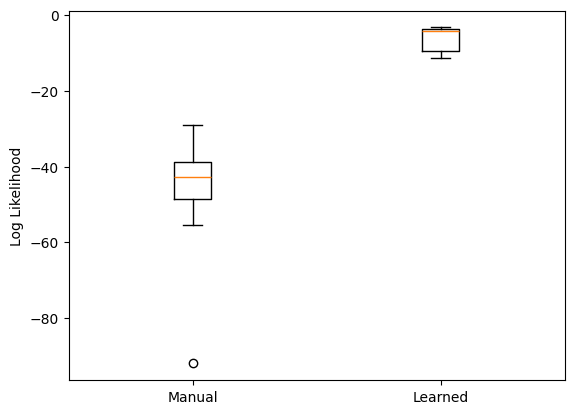

In [22]:
plt.boxplot(np.array([Manual_, Learned_]).T)
plt.xticks([1, 2], ['Manual', 'Learned'])
plt.ylabel('Log Likelihood')
plt.show()

In [16]:
LogLikelihood = np.load('../Data/HMMStates/LL.npy', allow_pickle=True)
print(LogLikelihood[:,2])

[-18152914.20351119 -18100708.79847356 -18009292.18370712
 -18204748.45267076 -18266324.19227631 -17903890.34458693
 -18335350.97152016  -9029536.00348217 -18395894.2338539
 -18427466.70855271 -18978448.64852837 -20361557.47878259]


In [2]:
title = 'ShortSession7'

In [5]:
# ShortSession7
start, end = pd.Timestamp('2022-07-19 10:37:08.422299862'), pd.Timestamp('2022-07-19 16:04:43.376220226')
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
mouse_pos = mouse_pos[['x','y']]

In [7]:
obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())[:, :10*60*50]
np.save('../Data/MouseKinematicParameters/' + title + 'OBS.npy', obs)

P = np.load('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', allow_pickle=True)
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = P['sigma_a'].item(), P['sigma_x'].item(), P['sigma_y'].item(), P['sqrt_diag_V0_value'].item(), P['B'], P['Qe'], P['m0'], P['V0'], P['Z'], P['R']

#First 10 min of the data
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, m0, V0, Z, R = kinematics.LDSParameters_Learned(obs, sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, Z)
np.savez('../Data/MouseKinematicParameters/' + title + 'Parameters.npz', sigma_a = sigma_a, sigma_x = sigma_x, sigma_y = sigma_y, sqrt_diag_V0_value = sqrt_diag_V0_value, B = B, Qe = Qe, m0 = m0, V0 = V0, Z = Z, R = R)

In [9]:
obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())
Q = (sigma_a**2) * Qe
filterRes = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
np.savez_compressed('../Data/ProcessedMouseKinematics/' + title + 'filterRes.npz', **filterRes)
        
# Smoothing
smoothRes = inference.smoothLDS_SS( 
        B=B, xnn=filterRes["xnn"], Vnn=filterRes["Vnn"],
        xnn1=filterRes["xnn1"], Vnn1=filterRes["Vnn1"], m0=m0, V0=V0)
np.savez_compressed('../Data/ProcessedMouseKinematics/' + title + 'smoothRes.npz', **smoothRes)

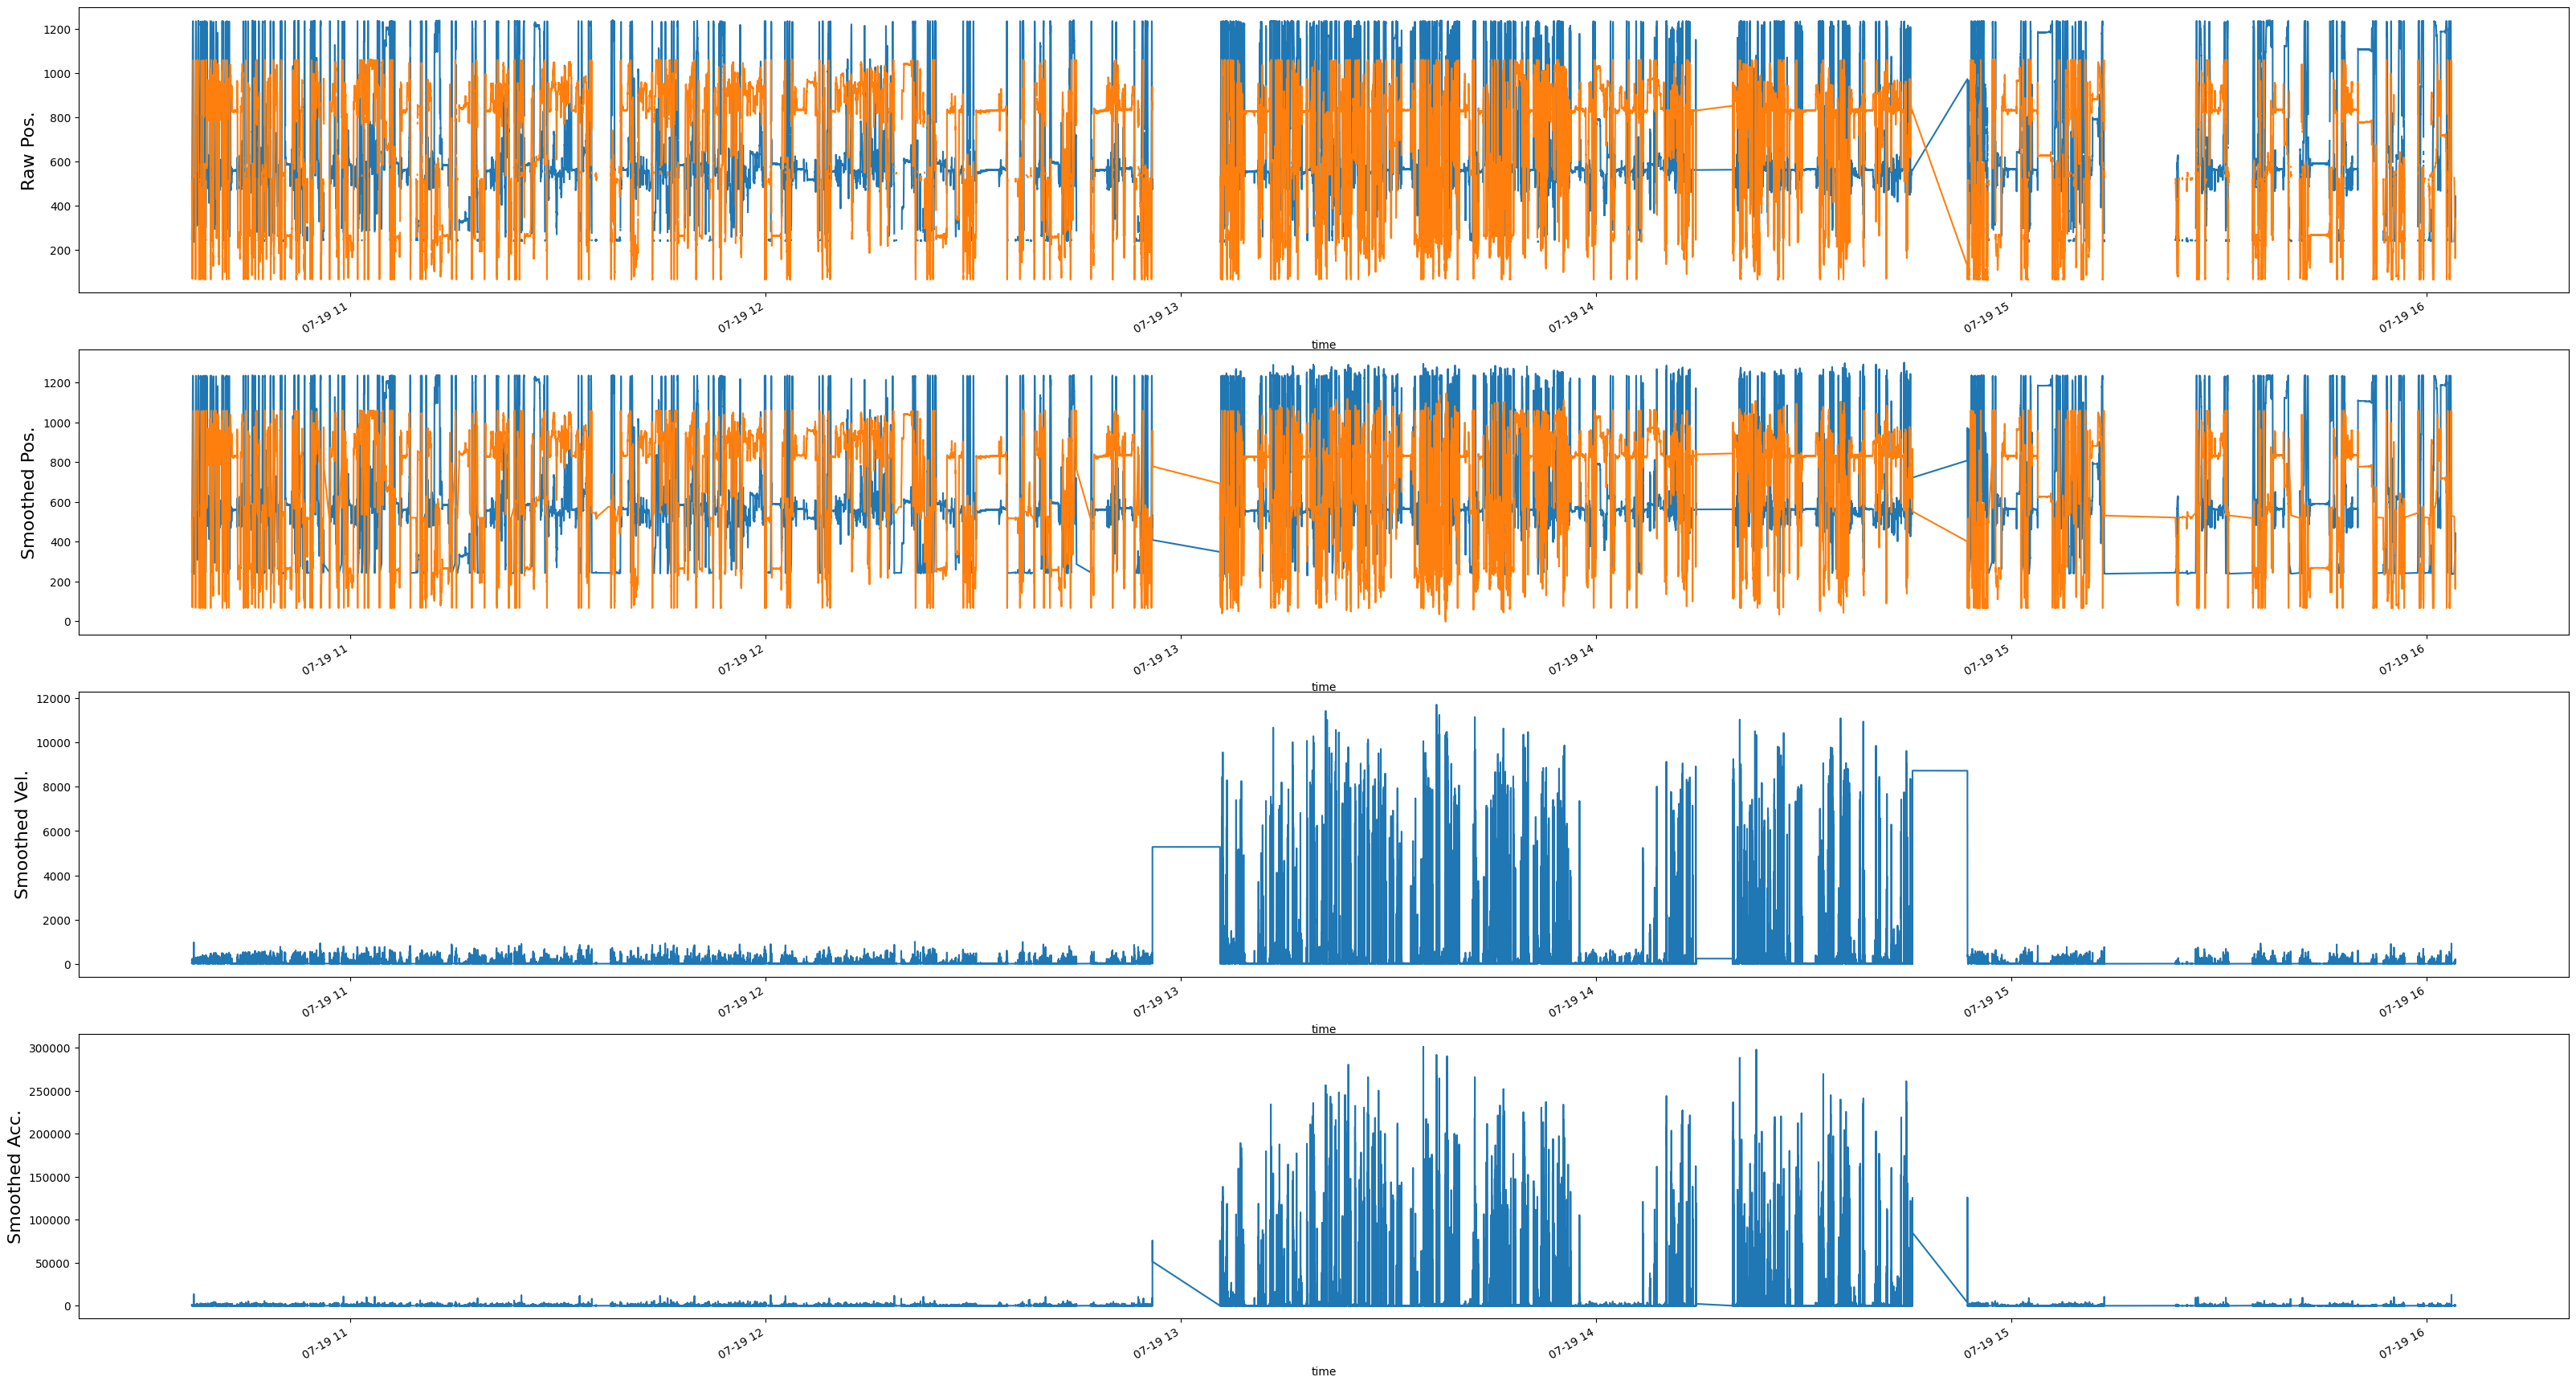

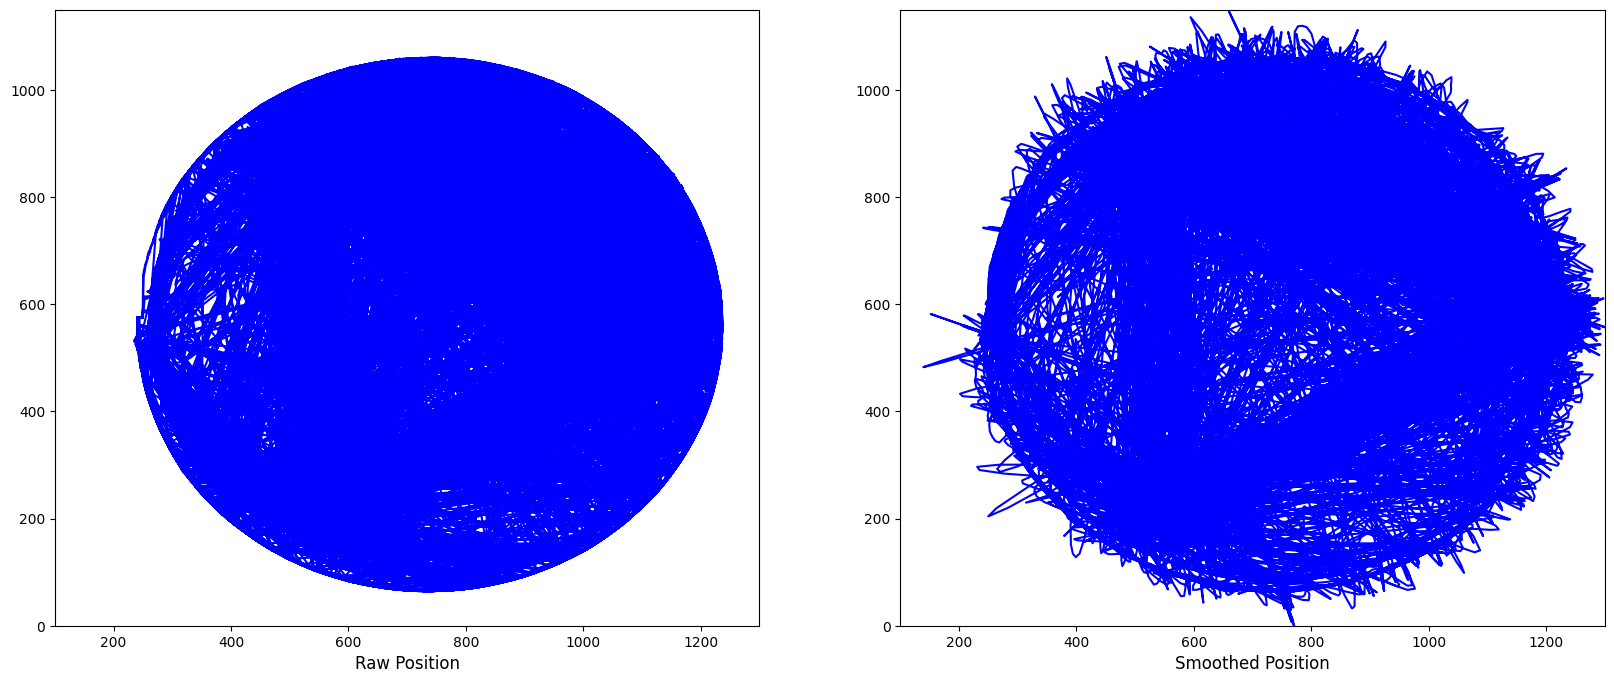

In [11]:
start, end = pd.Timestamp('2022-07-19 10:37:08.422299862'), pd.Timestamp('2022-07-19 16:04:43.376220226')
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end, fix_nan=False)

# Add smoothed kinematics data to mouse_pos
kinematics.AddKinematics(title, mouse_pos)
    
#mouse_pos = mouse_pos.dropna(subset=['x'])
    
# Draw plots
fig, axs = plt.subplots(4,1, figsize = (40,24))
mouse_pos.x.plot(ax = axs[0])
mouse_pos.y.plot(ax = axs[0])
mouse_pos.smoothed_position_x.plot(ax = axs[1])
mouse_pos.smoothed_position_y.plot(ax = axs[1])
mouse_pos.smoothed_speed.plot(ax = axs[2])
mouse_pos.smoothed_acceleration.plot(ax = axs[3])
    
axs[0].set_ylabel('Raw Pos.',fontsize = 16)
axs[1].set_ylabel("Smoothed Pos.",fontsize = 16)
axs[2].set_ylabel("Smoothed Vel.",fontsize = 16)
axs[3].set_ylabel("Smoothed Acc.",fontsize = 16)
plt.savefig('../Images/Kinematics/' + title+'.png')
plt.show()

fig, axs = plt.subplots(1,2,figsize = (20, 8))
axs[0].plot(mouse_pos.x, mouse_pos.y, color = 'blue')
axs[1].plot(mouse_pos.smoothed_position_x, mouse_pos.smoothed_position_y, color = 'blue')
axs[0].set_xlabel('Raw Position', fontsize = 12)
axs[1].set_xlabel('Smoothed Position', fontsize = 12)
for i in range(2):
    axs[i].set_xlim(100, 1300)
    axs[i].set_ylim(0, 1150)
plt.savefig('../Images/Positions/' + title+'.png')
plt.show()

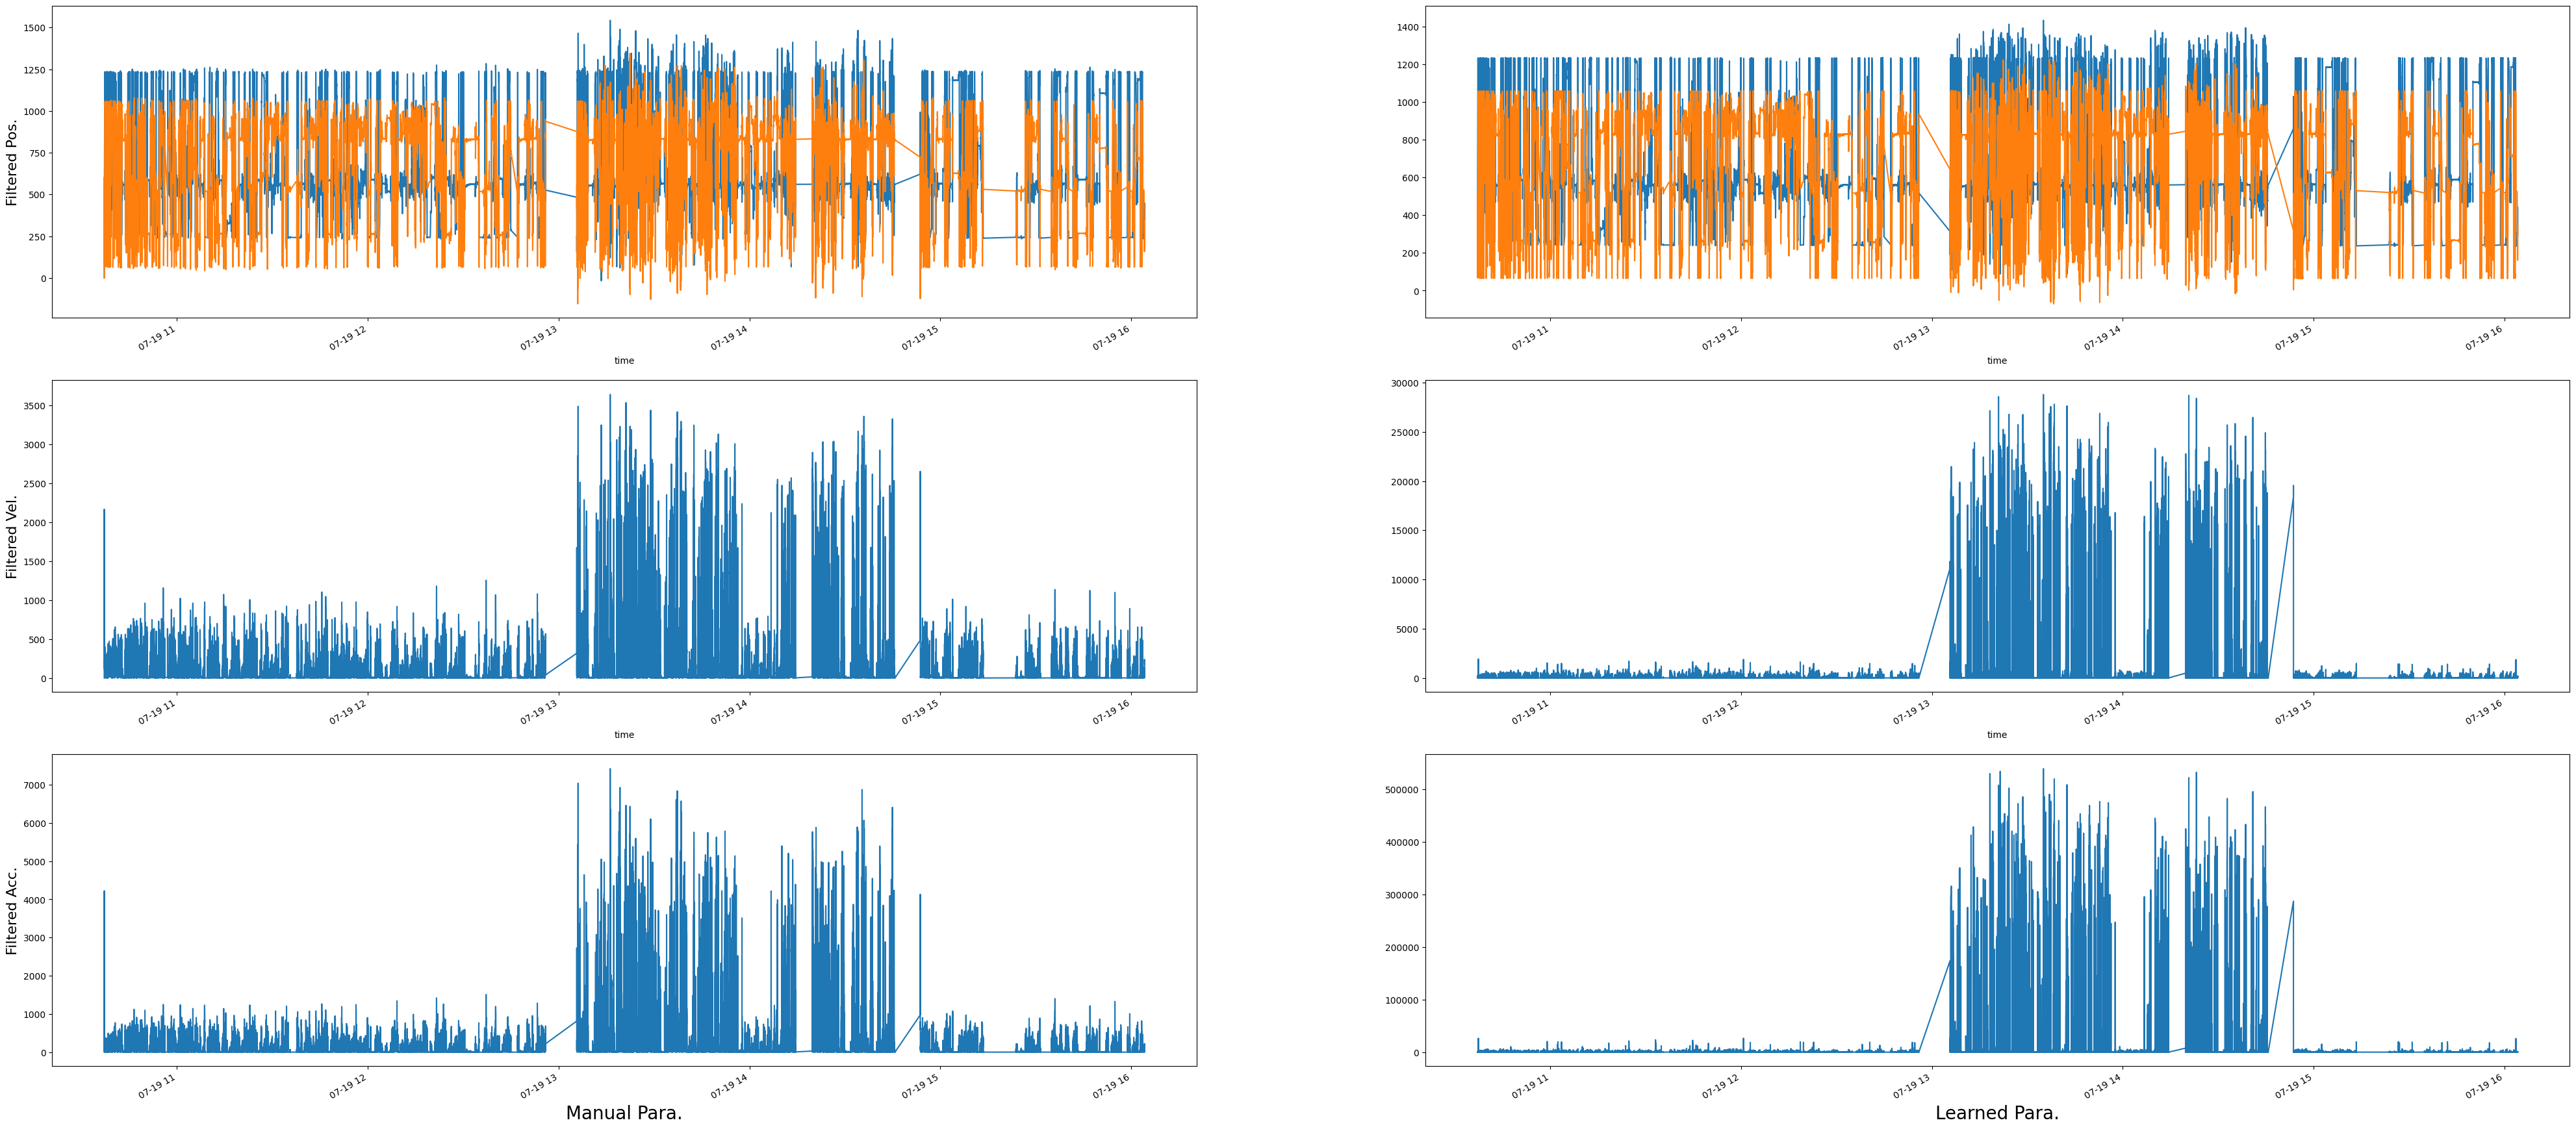

In [12]:
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
    
obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())
    
fig, axs = plt.subplots(3,2, figsize = (50,24))
    
# Manual parameters
sigma_a, sigma_x, sigma_y, sqrt_diag_V0_value, B, Qe, m0, V0, Z, R = kinematics.LDSParameters_Manual(dt=0.02)    
Q = sigma_a**2*Qe

filterRes_m = inference.filterLDS_SS_withMissingValues_np(
        y=obs, B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)
kinematics.AddKinematics_filter(mouse_pos, filterRes_m)
    
mouse_pos.filtered_position_x.plot(ax = axs[0,0])
mouse_pos.filtered_position_y.plot(ax = axs[0,0])
mouse_pos.filtered_speed.plot(ax = axs[1,0])
mouse_pos.filtered_acceleration.plot(ax = axs[2,0])
    
# Learned parameters
filterRes_l = np.load('../Data/ProcessedMouseKinematics/' + title+'filterRes.npz')
kinematics.AddKinematics_filter(mouse_pos, filterRes_l)

mouse_pos.filtered_position_x.plot(ax = axs[0,1])
mouse_pos.filtered_position_y.plot(ax = axs[0,1])
mouse_pos.filtered_speed.plot(ax = axs[1,1])
mouse_pos.filtered_acceleration.plot(ax = axs[2,1])
    
    
axs[0,0].set_ylabel('Filtered Pos.',fontsize = 16)
axs[1,0].set_ylabel("Filtered Vel.",fontsize = 16)
axs[2,0].set_ylabel("Filtered Acc.",fontsize = 16)

axs[2,0].set_xlabel('Manual Para.',fontsize = 20)
axs[2,1].set_xlabel("Learned Para.",fontsize = 20)
plt.savefig('../Images/CompareParameters/' + title+'.png')
plt.show()

ll1, ll2 = filterRes_m['logLike'][0,0]/len(filterRes_m['xnn'][0][0]), filterRes_l['logLike'][0,0]/len(filterRes_l['xnn'][0][0])

In [13]:
print(ll1, ll2)

-1199.7105012109844 -7737.510874128208


In [14]:
LL_Manual = np.array([-50.75167087,   -33.7864688 ,   -55.46295733,   -91.97254088,
         -28.98819496,   -42.7243799 ,   -42.29880334, 
         -37.5178155 ,   -46.46203257,   -45.12113761,   -39.93614478])
LL_Learned = np.array([   -4.07062939,   -11.17530799,    -3.45503605,    -7.67185293,
          -3.3124826 ,    -3.39820032,   -11.38716065, 
          -8.28957626,    -4.15754937,    -4.12955896,   -10.97325871])

In [15]:
np.save('../Data/MouseKinematicParameters/ShortSessions_LL_Manual.npy', LL_Manual)
np.save('../Data/MouseKinematicParameters/ShortSessions_LL_Learned.npy', LL_Learned)

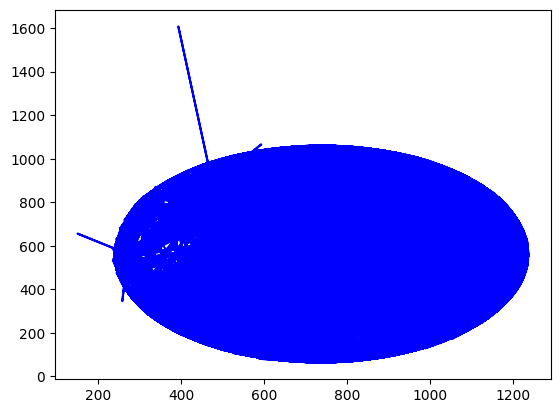

In [37]:
plt.plot(mouse_pos.x, mouse_pos.y, color = 'blue')
plt.show()

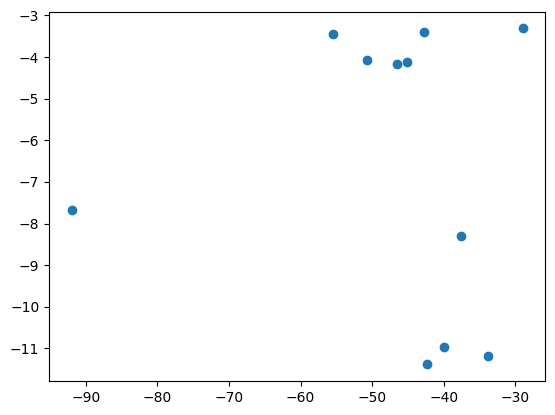

In [ ]:
plt.scatter(Manual_, Learned_)
plt.show()